# Warning

The code and the sample data is not permitted to be shared publicly in any form. 

© 2025 Caner Özer & Abdullah Kavaklı & Behçet Uğur Töreyin. All rights reserved.


# Installation
To start your homework, you need to install requirements. We recommend that you use conda environment for this homework.

Assuming that you have a just-installed Ubuntu 22.04 machine, below are the commands you need to run:

1. apt-get update
2. apt-get install -y curl gcc
3. curl -O https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
4. bash Miniconda3-latest-Linux-x86_64.sh
5. source ~/.bashrc
6. conda create -n lfdhw2.2 python=3.10.13 numpy=2.2.4 matplotlib=3.10.0 contourpy=1.3.1 scipy=1.15.1 scikit-learn=1.6.1 nibabel=5.3.2
7. conda activate lfdhw2.2
8. conda install -c conda-forge notebook pandas

In [1]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

from src.kmeans import KMeans

from src.pca import PCA
from src.utils import calculate_psnr

# A. Principtal Component Analysis

In this part, you will implement PCA from scratch for 3D brain MRI dataset. You need to consider each of the slices of the 3D dataset as a 2D image and apply PCA on each of these 2D images. While processing the slices, you need to ignore the slices that are all zeros and consider the rows as your samples during dimensionality reduction. After obtaining the principal components in such a manner, you will use them to reduce the dimensionality of the dataset and reconstruct the brain slices and then the patient volume.

Steps:
1. Load the dataset
2. Apply PCA on each slice
3. Reduce the dimensionality of the dataset
4. Reconstruct the brain slices and patient volume

In [2]:
data_path = "data/0001-image.nii.gz"
data_path_ma = "data/0001-image_ma.nii.gz"

# Load the dataset
img = nib.load(data_path)
data = img.get_fdata()[:,:,:,0]

In [3]:
indexes = []
n_components = [1, 2, 4, 8, 16, 32, 64, 144]
psnr_results = {n: [] for n in n_components}
valid_psnr_results = {n: [] for n in n_components}
reconstructed_slices = {n: [] for n in n_components}

for i in range(data.shape[2]):
    # Get the slice
    slice = data[:, :, i]

    indexes.append(i)
    
    # No need to apply PCA on the slice if it is all zeros
    if np.all(slice == 0):
        for n in n_components:
            reconstructed_slices[n].append(slice)
            psnr_results[n].append(np.nan)
        continue

    for n in n_components:
        pca_orig = PCA(n_components=n)
        pca_orig.fit(slice)
        reduced_slice_orig = pca_orig.transform(slice)
        reconstructed_slice = pca_orig.inverse_transform(reduced_slice_orig)

        psnr_results[n].append(calculate_psnr(slice, reconstructed_slice))
        valid_psnr_results[n].append(calculate_psnr(slice, reconstructed_slice))

        reconstructed_slices[n].append(reconstructed_slice)



Let's try to visualize the reconstructed slices for different `n_components`.

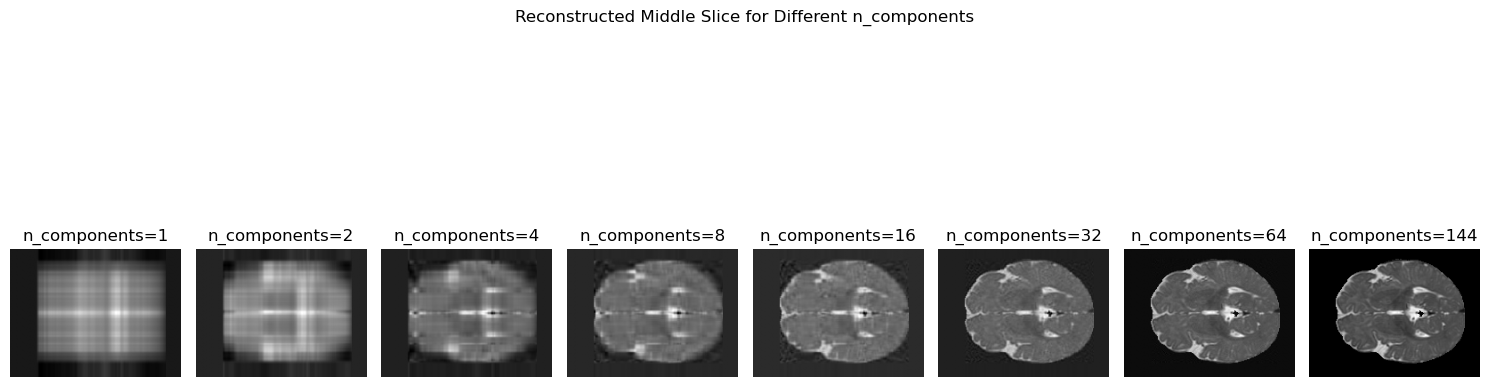

In [4]:
import matplotlib.pyplot as plt


# Visualize the middle slice for each n_component value
mid_index = len(indexes) // 2

plt.figure(figsize=(15, 6))
for idx, n in enumerate(n_components):
    plt.subplot(1, len(n_components), idx + 1)
    plt.title(f"n_components={n}")
    plt.imshow(reconstructed_slices[n][mid_index], cmap='gray')
    plt.axis('off')

plt.suptitle("Reconstructed Middle Slice for Different n_components")
plt.tight_layout()
plt.show()


We can also have a look at to the image quality of the reconstructed slices by measuring the PSNR of the reconstructed slices.

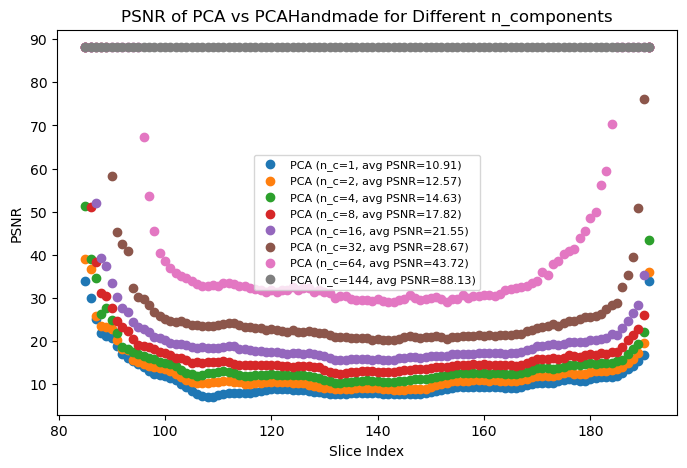

In [5]:
plt.figure(figsize=(8, 5))
plt.title("PSNR of PCA vs PCAHandmade for Different n_components")
plt.xlabel("Slice Index")
plt.ylabel("PSNR")

for n in n_components:
    mean_psnr_auth = np.mean(valid_psnr_results[n])    
    plt.scatter(indexes, psnr_results[n], label=f"PCA (n_c={n}, avg PSNR={mean_psnr_auth:.2f})")

plt.legend(fontsize=8)
plt.show()

# B. k-Means Clustering

In this part, we will implement k-Means clustering on the reconstructed slices. We will use the k-Means clustering algorithm to cluster the reconstructed slices into k clusters. We will then map the clusters to the true labels and calculate the clustering accuracy.

Let's start by loading the corresponding segmentation map of the original data. The segmentation map includes annotation information corresponding 3 different anatomical structures: white matter, gray matter and cerebrospinal fluid. Keeping this in mind, we will implement k-Means clustering on the reconstructed slices while selecting an appropriate `k` value. You may want to select either the original data or an appropriate reconstructed slice for this part.

In [6]:
segm_path = "data/0001-label.nii.gz"

segm = nib.load(segm_path)
true_data = segm.get_fdata()[:,:,:,0]

In [7]:
import pandas as pd
from src.utils import map_clusters_to_labels_2d, clustering_accuracy

# Run KMeans clustering only for k=4 and n=64, wee choosed 4 because of....(complete the sentence)
k = 4
n = 32

# Initialize a DataFrame to store the class-wise Dice scores
clus_accs_df = pd.DataFrame(columns=['Class ID', 'Clustering Accuracy'])

# Apply KMeans clustering
kmeans = KMeans(n_clusters=k, random_state=42)
mid_index = len(reconstructed_slices[n]) // 2
flat_slice = reconstructed_slices[n][mid_index].reshape(-1, 1)
true_slice = true_data[:,:,mid_index]
segmented = kmeans.fit_predict(reconstructed_slices[n][mid_index].reshape(-1, 1))
segmented = segmented.reshape(*reconstructed_slices[n][mid_index].shape)

# Map clusters to labels
mapped_labels = map_clusters_to_labels_2d(segmented, true_slice, k)

# Calculate clustering accuracy
clus_acc = clustering_accuracy(mapped_labels, true_slice)
print("Clustering Accuracy: ", clus_acc)

Clustering Accuracy:  0.7786458333333334


We can observe how the segmentation maps look like.

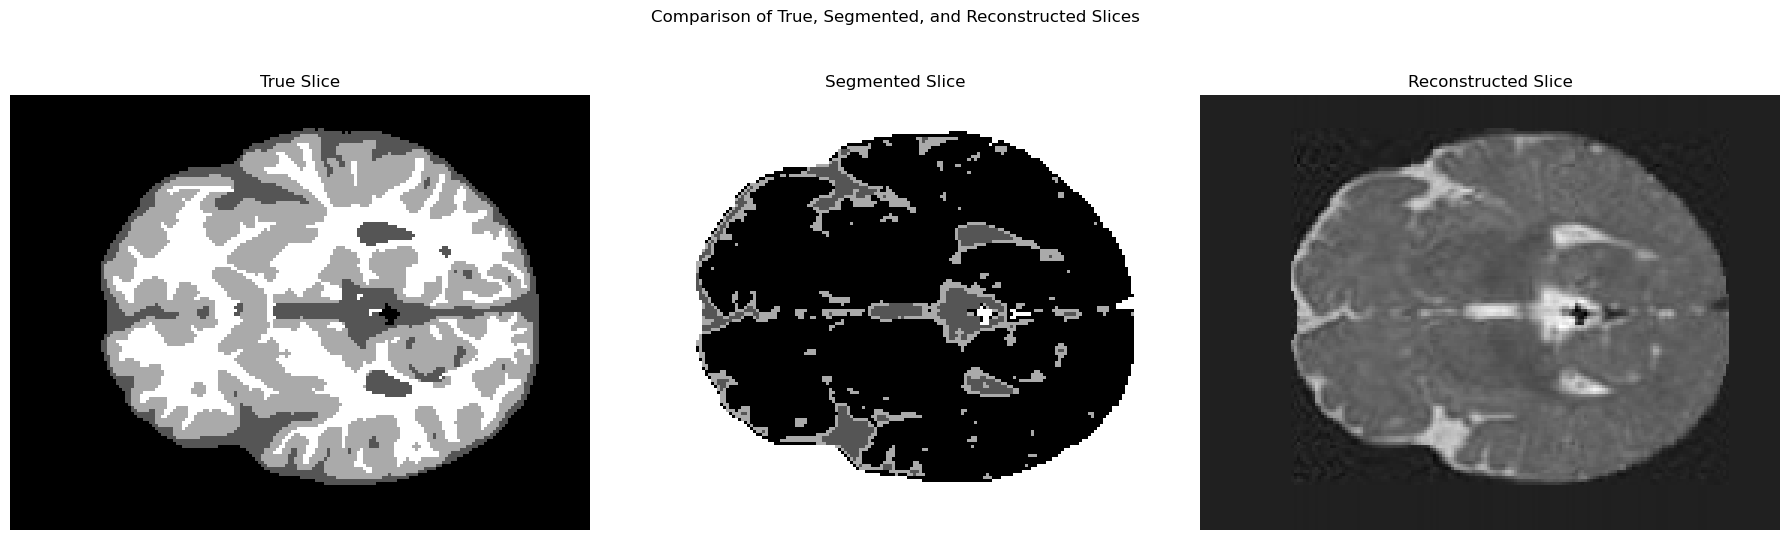

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Display the true slice
ax[0].imshow(true_slice, cmap='gray')
ax[0].set_title('True Slice')
ax[0].axis('off')

# Display the segmented slice
ax[1].imshow(segmented, cmap='gray')
ax[1].set_title('Segmented Slice')
ax[1].axis('off')

# Display the reconstructed slice
ax[2].imshow(reconstructed_slices[n][mid_index], cmap='gray')
ax[2].set_title('Reconstructed Slice')
ax[2].axis('off')

plt.suptitle("Comparison of True, Segmented, and Reconstructed Slices")
plt.tight_layout()
plt.show()


Now, let's try to work with different `n` and `k` values. We will use the same reconstructed slices and true data as before. We will calculate the clustering accuracy for each combination of `n` and `k` values and demonstrate the results in a table.

In [9]:
# Initialize a dictionary to store clustering accuracies
clustering_accuracies = {}

# Iterate over all possible n parameters
for n in n_components:
    clustering_accuracies[n] = {}
    # Iterate over a range of k values from 2 to 7
    for k in range(2, 8):
        # Apply KMeans clustering
        kmeans = KMeans(n_clusters=k, random_state=42)
        mid_index = len(reconstructed_slices[n]) // 2
        flat_slice = reconstructed_slices[n][mid_index].reshape(-1, 1)
        true_slice = true_data[:, :, mid_index]
        segmented = kmeans.fit_predict(flat_slice)
        segmented = segmented.reshape(*reconstructed_slices[n][mid_index].shape)

        # Map clusters to labels
        mapped_labels = map_clusters_to_labels_2d(segmented, true_slice, k)

        # Calculate clustering accuracy
        clus_acc = clustering_accuracy(mapped_labels, true_slice)
        clustering_accuracies[n][k] = clus_acc

# Create DataFrame with n as index and k as columns
clustering_accuracies_df = pd.DataFrame.from_dict(clustering_accuracies, orient='index')
clustering_accuracies_df.columns = [f'k={k}' for k in range(2, 8)]
clustering_accuracies_df.index.name = 'n'

# Function to bold the max in each row
def highlight_max(s):
    is_max = s == s.max()
    return ['font-weight: bold' if v else '' for v in is_max]

# Apply the style
styled_df = clustering_accuracies_df.style.apply(highlight_max, axis=1)

# Display the clustering accuracies table
display(styled_df)

,k=2,k=3,k=4,k=5,k=6,k=7
n,,,,,,
1,0.703776,0.690466,0.696904,0.702799,0.712131,0.715061
2,0.722765,0.715061,0.700376,0.699797,0.729311,0.738679
4,0.729962,0.754015,0.744104,0.738679,0.751519,0.757234
8,0.735677,0.764142,0.759946,0.752749,0.769893,0.766819
16,0.739764,0.774812,0.768446,0.777091,0.779405,0.775969
32,0.741500,0.780490,0.778646,0.782118,0.777850,0.783529
64,0.742477,0.782588,0.780744,0.784252,0.780635,0.787037
144,0.742477,0.782371,0.781359,0.784433,0.780780,0.783275


Which part of the first section of Assignment 2 could be asked in a more structured way? (Hint: design patterns)

I searched on web about main design patterns which are Strategy, Factory and Observer Patterns. And, I found this implementations which will enhance codes in that assignment:

### Strategy Pattern
For this section:
  
        logreg = LogisticRegression(max_iter=1000, random_state=42)
        svm = SVM(C=1.0, max_iter=1000, random_state=42)
        mlp = MLP(input_size=..., hidden_sizes=[32, 16], ...) 
Design Pattern Solution:
  
        class ModelStrategy(ABC):
            @abstractmethod
            def fit(self, X, y):
                pass
            
            @abstractmethod  
            def predict(self, X):
                pass
            
            @abstractmethod
            def get_name(self):
                pass
        
        class LogisticRegressionStrategy(ModelStrategy):
            def __init__(self, **kwargs):
                self.model = LogisticRegression(**kwargs)
            
            def fit(self, X, y):
                return self.model.fit(X, y)
            
            def predict(self, X):
                return self.model.predict(X)
            
            def get_name(self):
                return "Logistic Regression"
        
        # Usage
        models = [
            LogisticRegressionStrategy(max_iter=1000),
            SVMStrategy(C=1.0),
            MLPStrategy(hidden_sizes=[32, 16])
        ]
        
### Factory Pattern
For this section:

        scaler = StandardScaler()
        X = scaler.fit_transform(X)
        
        y_train_svm = np.where(y_train == 0, -1, 1)
        y_train_oh = one_hot(y_train_mnist1d, 10)
Design Pattern Solution:

        class DataPreprocessorFactory:
        @staticmethod
        def create_preprocessor(model_type, dataset_type):
            if model_type == "SVM":
                return SVMPreprocessor()
            elif model_type == "MLP":
                return MLPPreprocessor()
            else:
                return StandardPreprocessor()
    
        class SVMPreprocessor:
            def preprocess(self, X, y):
                scaler = StandardScaler()
                X_scaled = scaler.fit_transform(X)
                y_binary = np.where(y == 0, -1, 1)
                return X_scaled, y_binary

### Observer Pattern
For this section:

        accuracies_1 = []
        accuracies_2 = []
        
        for seed in seeds:
            acc1 = accuracy_score(y_test, model1.predict(X_test))
            acc2 = accuracy_score(y_test, model2.predict(X_test))
            accuracies_1.append(acc1)
            accuracies_2.append(acc2)
Design Pattern Solution:

        class ResultsObserver(ABC):
        @abstractmethod
        def update(self, model_name, metrics):
            pass
    
        class AccuracyCollector(ResultsObserver):
            def __init__(self):
                self.results = defaultdict(list)
            
            def update(self, model_name, metrics):
                self.results[model_name].append(metrics['accuracy'])
        
        class ModelEvaluator:
            def __init__(self):
                self.observers = []
            
            def attach_observer(self, observer):
                self.observers.append(observer)
            
            def notify_observers(self, model_name, metrics):
                for observer in self.observers:
                    observer.update(model_name, metrics)
